<a href="https://colab.research.google.com/github/stanbsky/int2_image_classifier/blob/main/kaggle94gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# importing libraries
import torch
import torchvision
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor,ToPILImage
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tt
import numpy as np

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-kins96ns because the default path (/run/user/141228/cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
import torchvision.datasets as datasets

In [3]:
from numba import cuda
cuda.select_device(4)

<weakproxy at 0x7f26f8e9abd8 to Device at 0x7f26f8f067f0>

In [4]:
stats= ((0.4914,0.4822,0.4465),(0.2023,0.1994,0.2010)) #mean and std
train_tfm= tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), # transormation of data together
                       tt.RandomHorizontalFlip(),
                       tt.ToTensor()])
valid_tfm = tt.Compose([tt.ToTensor()])

In [5]:
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=train_tfm,
)

Files already downloaded and verified


In [6]:
# Download test data from open datasets.
test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=valid_tfm,
)

Files already downloaded and verified


In [7]:
valid_ds = test_data
train_ds = training_data
train_ds

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [8]:
def show_image(img,label):
    print('Label: ', train_ds.classes[label],"("+str(label)+")")
    plt.imshow(img.permute(1,2,0))

In [9]:
batch_size=800

In [10]:
# Dataloader to load data in batches(mini batch)
train_dl= DataLoader(train_ds,batch_size,shuffle=True, num_workers=2, pin_memory=True)
valid_dl= DataLoader(valid_ds, batch_size, num_workers=2,pin_memory=True)

In [11]:
def show_batch(dl):
    for images, labels in dl:
        fig,ax= plt.subplots(figsize=(12,12))
        ax.set_xticks([]) #hide ticks
        ax.set_yticks([])
        ax.imshow(make_grid(images[:64],nrow=8).permute(1,2,0))
        break # printing only first 64 images from first batch

In [12]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [13]:
device = get_default_device()
device

device(type='cuda')

In [14]:
train_dl= DeviceDataLoader(train_dl,device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [15]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [16]:
def conv_block(in_channels, out_channels, stride=1):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    return nn.Sequential(*layers)

def shortcut(in_channels, out_channels):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=2)

class ResNet(ImageClassificationBase):
    def __init__(self, in_channels, num_classes, n):
        super().__init__()
        
        self.n = n
        
        # 32x32 map
        self.conv1 = conv_block(in_channels, 16)
        self.reg32 = nn.Sequential(conv_block(16,16), conv_block(16,16))
        
        # 16x16 map
        self.entry16 = nn.Sequential(conv_block(16, 32, stride=2), conv_block(32, 32))
        self.short16 = shortcut(16, 32)
        self.reg16 = nn.Sequential(conv_block(32, 32), conv_block(32, 32))
        
        # 8x8 map
        self.entry8 = nn.Sequential(conv_block(32, 64, stride=2), conv_block(64, 64))
        self.short8 = shortcut(32, 64)
        self.reg8 = nn.Sequential(conv_block(64, 64), conv_block(64, 64))
        
        self.classifier = nn.Sequential(nn.AvgPool2d(kernel_size=8, stride=None, padding=0), 
                                        nn.Linear(64, num_classes),
                                       nn.Softmax())
        # FOR DEBUGGING
        self.avg = nn.AvgPool2d(kernel_size=8, stride=None, padding=0)
        self.flat = nn.Flatten()
        self.fcl = nn.Linear(64, num_classes)
        self.sm = nn.Softmax()
        
    def forward(self, xb):
        out = self.conv1(xb)
        
        for i in range(self.n):
            out = self.reg32(out) + out
            
        out = self.entry16(out) + self.short16(out)
        for i in range(self.n - 1):
            out = self.reg16(out) + out
            
        out = self.entry8(out) + self.short8(out)
        for i in range(self.n - 1):
            out = self.reg8(out) + out

        #out = self.classifier(out)
        out = self.avg(out)
        out = self.flat(out)
        out = self.fcl(out)
        out = self.sm(out)
        
        return out

In [17]:
# n=3 => ResNet20
model= to_device(ResNet(3,10,3), device)

In [18]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()  # Realsing cuda memory otherwise might get cuda out of memory error
    history = []
    
    #custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay, momentum=0.5, nesterov=True)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train() #Setting training mode
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [19]:
history = [evaluate(model, valid_dl)]
history

/home/userfs/s/sb2444/.local/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[{'val_loss': 2.3026275634765625, 'val_acc': 0.0955769270658493}]

In [20]:
epochs = 100
max_lr = 0.08
grad_clip = 0.1
weight_decay = 5e-5
opt_func = torch.optim.SGD

In [21]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

/home/userfs/s/sb2444/.local/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch [0], train_loss: 2.2878, val_loss: 2.2523, val_acc: 0.2089
Epoch [1], train_loss: 2.2166, val_loss: 2.1968, val_acc: 0.2690
Epoch [2], train_loss: 2.1599, val_loss: 2.1426, val_acc: 0.3243
Epoch [3], train_loss: 2.1027, val_loss: 2.1029, val_acc: 0.3653
Epoch [4], train_loss: 2.0559, val_loss: 2.1551, val_acc: 0.2925
Epoch [5], train_loss: 2.0047, val_loss: 2.0591, val_acc: 0.3997
Epoch [6], train_loss: 1.9606, val_loss: 2.0561, val_acc: 0.4013
Epoch [7], train_loss: 1.9275, val_loss: 2.1128, val_acc: 0.3355
Epoch [8], train_loss: 1.8951, val_loss: 2.0978, val_acc: 0.3522
Epoch [9], train_loss: 1.8670, val_loss: 2.1292, val_acc: 0.3188
Epoch [10], train_loss: 1.8443, val_loss: 1.9778, val_acc: 0.4812
Epoch [11], train_loss: 1.8266, val_loss: 1.9989, val_acc: 0.4562
Epoch [12], train_loss: 1.8128, val_loss: 2.0651, val_acc: 0.3880
Epoch [13], train_loss: 1.8032, val_loss: 1.9568, val_acc: 0.5013
Epoch [14], train_loss: 1.7895, val_loss: 2.0332, val_acc: 0.4195
Epoch [15], train_lo

In [22]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.figure(figsize=(10,6))
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

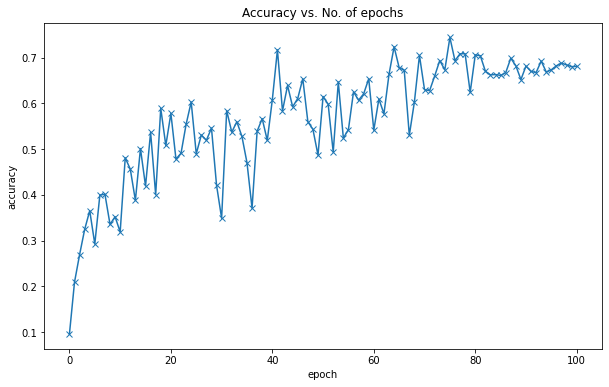

In [23]:
plot_accuracies(history)

In [24]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.figure(figsize=(10,6))
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

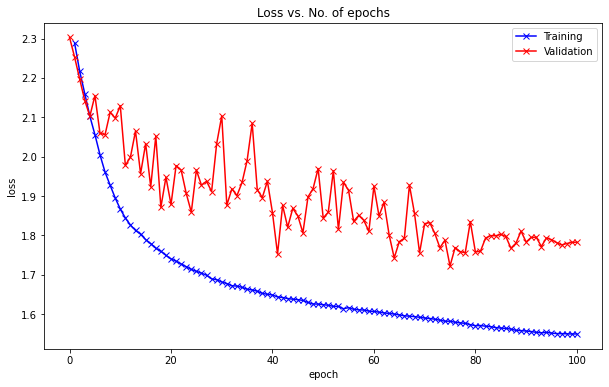

In [25]:
plot_losses(history)

In [26]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.figure(figsize=(10,6))
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

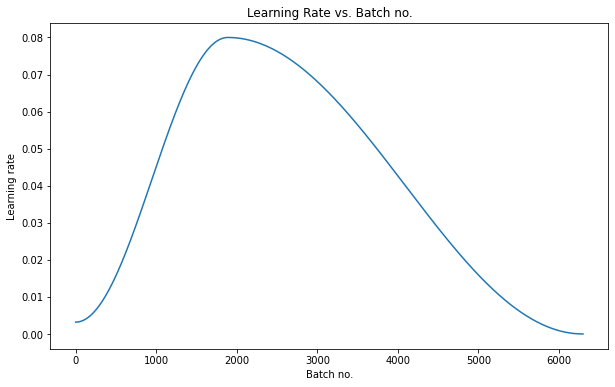

In [27]:
plot_lrs(history)